In [1]:
pip install keras-nightly

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install --upgrade keras-cv
!pip install --upgrade keras-hub
!pip install --upgrade keras

In [ ]:
!pip install opencv-contrib-python

In [25]:
pip install pydot


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [14]:
import keras
print(keras.__version__)

3.6.0.dev2024101003


In [15]:
import os 
import cv2
import math
import random 
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import keras
from keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [24]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense
# Import 'tanh' from keras.activations
from tensorflow.keras.activations import tanh

In [16]:
img_height,img_width=64,64
sequence_length=40
class_list=['Arson','Assault']

In [17]:
def frames_extraction(video_path):
    frames_list=[]
    video_reader=cv2.VideoCapture(video_path)
    video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window=max(int(video_frames_count/sequence_length),1)
    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window)
        sucess, frame=video_reader.read()
        if not sucess:
            break
        resized_frame=cv2.resize(frame,(img_height,img_width))
        normalized_frame=resized_frame/255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list


In [18]:
def create_dataset():
    features=[]
    labels=[]
    video_path=[]
    for class_index,class_name in enumerate(class_list):
        print(f'Extracting class:{class_name}')
        path=f'E:/datasets/UCF/Anomaly-Videos/Anomaly-Videos-Part-1/{class_name}'
        file_list=os.listdir(f'E:/datasets/UCF/Anomaly-Videos/Anomaly-Videos-Part-1/{class_name}')
        for file_index,file_name in enumerate(file_list):
            video_file_path=os.path.join(path,file_name)
            frames=frames_extraction(video_file_path)
            # if len(frames)==sequence_length:
            features.append(frames)
            labels.append(int(class_index))
            video_path.append(video_file_path)
    features=np.array(features)
    labels=np.array(labels)
    return features,labels,video_path

In [19]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [20]:
features, labels, videopath=create_dataset()

Extracting class:Arson


Extracting class:Assault


In [ ]:
one_hot_encoded_labels=to_categorical(labels)
one_hot_encoded_labels

In [22]:
features_train,features_test, labels_train, labels_test=train_test_split(features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant)

In [ ]:
features_train[0]

In [25]:
def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation=tanh, data_format="channels_last", recurrent_dropout=0.2, return_sequences=True, input_shape=(sequence_length, img_height, img_width, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation=tanh, data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation=tanh, data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation=tanh, data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())
    model.add(Dense(len(class_list), activation="softmax"))
    model.summary()
    return model

In [26]:
convlstm_model=create_convlstm_model()
print("model created successfully")

c:\Users\Namith H Sarode\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 40, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 40, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 40, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 40, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 40, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 40, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 40, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 40, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 40, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 40, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 40, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 40, 3, 3, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        11,522 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,522 (173.91 KB)

 Trainable params: 44,522 (173.91 KB)

 Non-trainable params: 0 (0.00 B)

model created successfully


In [27]:
plot_model(convlstm_model, to_file='convlstm_model_structure_plot.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [28]:
early_stopping_callback=EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

convlstm_model_training_history=convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5130 - loss: 0.7510 - val_accuracy: 0.3667 - val_loss: 0.7017
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4254 - loss: 0.6988 - val_accuracy: 0.3667 - val_loss: 0.6996
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4191 - loss: 0.6984 - val_accuracy: 0.5667 - val_loss: 0.6907
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5146 - loss: 0.6922 - val_accuracy: 0.3667 - val_loss: 0.6969
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4368 - loss: 0.6961 - val_accuracy: 0.7000 - val_loss: 0.6898
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 999ms/step - accuracy: 0.5644 - loss: 0.6889 - val_accuracy: 0.6000 - val_loss: 0.6858
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 932ms/step - accuracy: 0.5955 - loss: 0.6866 - val_accuracy: 0.5667 - val_loss: 0.6926
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 916ms/step - accuracy: 0.5913 - loss: 0.6850 - val_accuracy: 0.4000 - 

In [29]:
model_evalauation_history=convlstm_model.evaluate(features_test, labels_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 914ms/step - accuracy: 0.5475 - loss: 0.6974


In [30]:
import matplotlib.pyplot as plt

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1=model_training_history.history[metric_name_1]
  metric_value_2=model_training_history.history[metric_name_2]

  epochs=range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

  plt.title(str(plot_name))
  plt.legend()

  plt.show()

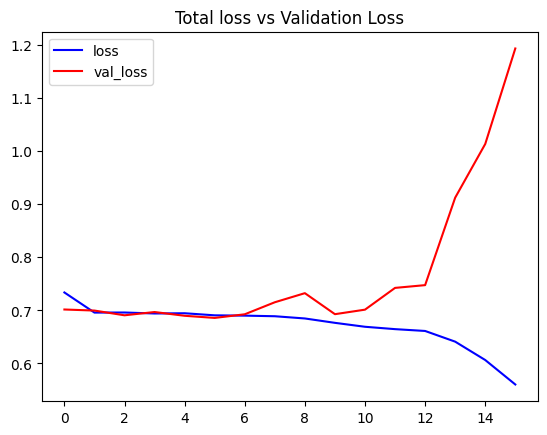

In [31]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total loss vs Validation Loss')


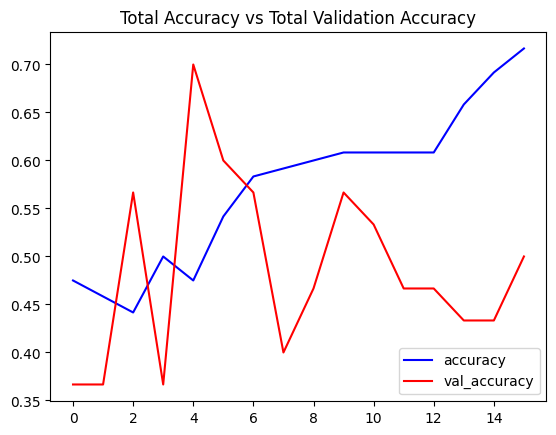

In [32]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')
